# 8.2 从小数据集训练 cnn 网络

计算机视觉的模型,开始只有一个非常小的数据集是非常普遍的情况,这里的小数据集的规模可能从几百到几万不等.

这一节我们将专注于分类猫狗的模型,包含 5000 张图片(猫狗各一半),2000 训练,1000 验证,2000 测试.

回顾一下第 6 章的内容.

- 首先我们要实现一个小模型,能超过基线(50%)的那种.书中给的正确率是 70%.
- 之后要开始调整过拟合,通过数据增强,模型的正确率能达到 80%~85%.
- 之后 8.3 节,我们会介绍使用预训练模型和预训练模型微调,最终的正确率等达到 98.5%.

小数据集解决图像分类问题的工具箱

- 从头训练的小型模型
- 预训练的网络做特征提取
- 预训练网络微调


## 深度学习与小数据问题的相关性

深度学习的基础是数据,只有大量数据可用时,深度学习才会有效.这样的说话在哪都听说过,说的没错.深度学习的基本特性就在大量数据中找到模式,而无需人工干预的特征工程.这只有咋拥有大量样本时才能实现,尤其是对图像识别这样的高维数据.

但是对于初学者,这个大量是相对的.虽然只用几十个样本训练卷积神经网络解决问题是不可能的.但是如果问题较为简单,模型很小,正则化很好,那几百个样本可能就足够了.同时 cnn 学习的是局部的特征,对图像的利用更加高效,非常节约训练样本.

此外深度学习模型的本质具有高度的复用性,在一个大规模数据集上训练好的模型,只需要很小的修改就能复用在完全不同的问题上.在下一节中我们将会用到预训练的模型.


## 下载数据集

和之前的例子不同,我们要使用的数据集并没有包含在 keras 中,我们要用的数据集是 kaggle 提供的,是 2013 年底计算机视觉竞赛的一部分.需要在 `www.kaggle.com/c/dogs-vs-cats/data` 下载,下载前需要注册 kaggle 账号,同时经过手机号验证(+86 也没问题).

我们需要下载的是 train.zip 共 543MB.

原书提供了在 google colab 的下载方式,在这里 [Downloading a Kaggle dataset in Google Colaboratory](https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-8/v-7/80)


图片都是 jpeg 格式,下面是一些示例图片.

![dog_and_cat_samples](dog_and_cat_samples.png)


当然不出预料,当年胜利的参赛者使用的都是 cnn,最好的效果达到了 95%.

这个数据集规模实在太大了,我们将取需要的数据,重新划分文件夹.

```shell
cats_vs_dogs_small/
...train/
......cat/
......dog/
...validation/
......cat/
......dog/
...test/
......cat/
......dog/
```


In [1]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")  #存放原始数据的文件夹
new_base_dir = pathlib.Path("cats_vs_dogs_small")  # 小数据集文件夹


def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)  #创建文件夹
        fnames = [
            f"{category}.{i}.jpg" for i in range(start_index, end_index)
        ]  #取源文件下需要图片
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)  #拷贝到新文件夹中


# make_subset("train", start_index=0, end_index=1000)  #训练集
# make_subset("validation", start_index=1000, end_index=1500)  #验证集
# make_subset("test", start_index=1500, end_index=2500)  #测试集


重新构建小数据集的程序如上,程序功能见注释.

现在我们拥有了一个非常平衡的二元数据集,包括 2000 张训练 1000 张验证 2000 张测试.


## 构建模型

我们这一小节要开始构建模型,类型与 8.1 小节类似,不过这里我们要处理的图片大得多,需要更多 cnn 和 maxpooling.


In [2]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.experimental.preprocessing.Rescaling(1. / 255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

模型

- 最开始添加了一个缩放层,将图像输入 [0,255] 变成 [0,1]
- 5 个 cnn 层,4 个 maxpooling 层.
- 开始的输入是 180x180 ,最终输出是 7x7.
- 最终是二分类问题,因此最后是全连接层 1,激活函数是 sigmoid.


In [3]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 128)       73856 

In [4]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

模型设置

- 优化器: rmsprop,因为最终是 sigmoid.
- 损失函数: 二元交叉熵


## 预处理数据

jpeg 图像在输入模型前,需要张量化.这里因为有缩放层,数据缩放就不需要了.

具体步骤

- jpeg 解码成 rgb 像素
- 转换为 浮点张量
- 调整到同一尺寸,这里是 180x180
- 打包成批次大小,这里是 32


In [5]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dataset = image_dataset_from_directory(new_base_dir / "train",
                                             image_size=(180, 180),
                                             batch_size=32)  #训练集
validation_dataset = image_dataset_from_directory(new_base_dir / "validation",
                                                  image_size=(180, 180),
                                                  batch_size=32)  #验证集
test_dataset = image_dataset_from_directory(new_base_dir / "test",
                                            image_size=(180, 180),
                                            batch_size=32)  #测试集


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


别忘了这里是 python keras,这样的重复工作肯定有工具箱.

`image_dataset_from_directory`

- 第一个参数是图像所在的目录
- image_size 是输出图像的大小,这里是 180x180
- batch_size 是批次大小,这里是 32

之后一切自动化,自动将图片转换为浮点张量,宽高调整为 180x180,打包成批次 32.


In [6]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


这里容易看到训练数据已经按照批次大小 32 打包好了.


In [7]:
callbacks = [  #回调
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,  #只保存最佳模型
        monitor="val_loss")  #监控的指标
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,  #验证集
    callbacks=callbacks)


Epoch 1/30
63/63 [==============================] - 7s 64ms/step - loss: 0.7034 - accuracy: 0.5150 - val_loss: 0.6919 - val_accuracy: 0.5740
Epoch 2/30
63/63 [==============================] - 3s 53ms/step - loss: 0.7127 - accuracy: 0.5345 - val_loss: 0.6824 - val_accuracy: 0.6220
Epoch 3/30
63/63 [==============================] - 3s 53ms/step - loss: 0.7233 - accuracy: 0.5865 - val_loss: 0.6732 - val_accuracy: 0.5670
Epoch 4/30
63/63 [==============================] - 3s 53ms/step - loss: 0.6695 - accuracy: 0.6135 - val_loss: 0.6592 - val_accuracy: 0.6500
Epoch 5/30
63/63 [==============================] - 3s 53ms/step - loss: 0.6198 - accuracy: 0.6645 - val_loss: 0.6354 - val_accuracy: 0.6150
Epoch 6/30
63/63 [==============================] - 3s 53ms/step - loss: 0.5803 - accuracy: 0.6955 - val_loss: 0.6429 - val_accuracy: 0.6370
Epoch 7/30
63/63 [==============================] - 3s 53ms/step - loss: 0.5525 - accuracy: 0.7265 - val_loss: 0.5584 - val_accuracy: 0.7140
Epoch 8/30
63

训练 30 轮,这个在 cpu 上跑真的很慢,一定要在 gpu 上跑.


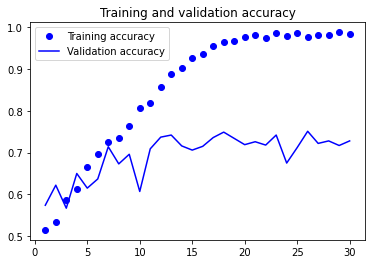

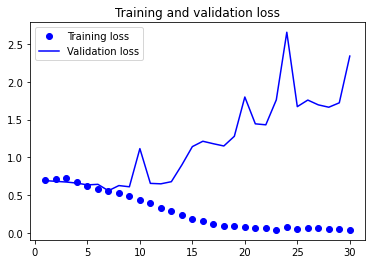

In [8]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()